# NIH Chest X-ray Dataset

### Applying DenseNet on NIH Chest dataset

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
#from generator import DataGenerator
import keras

<h1> Creating data for model </h1>

In [2]:
data = pd.read_csv('../input/Data_Entry_2017.csv')
data = data[data['Patient Age']<100] #removing datapoints which having age greater than 100
data_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'images*', '*', '*.png'))}
print('Scans found:', len(data_image_paths), ', Total Headers', data.shape[0])
data['path'] = data['Image Index'].map(data_image_paths.get)
data['Patient Age'] = data['Patient Age'].map(lambda x: int(x))
data.sample(3)

Scans found: 112120 , Total Headers 112104


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
48819,00012368_001.png,No Finding,1,12368,4,F,PA,2048,2500,0.168,0.168,NaN,../input/images_006/images/00012368_001.png
74804,00018362_000.png,Atelectasis|Effusion|Pleural_Thickening,0,18362,46,M,PA,2992,2991,0.143,0.143,NaN,../input/images_008/images/00018362_000.png
2795,00000743_001.png,No Finding,1,743,64,F,PA,2048,2500,0.171,0.171,NaN,../input/images_001/images/00000743_001.png


In [3]:
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data[c_label] = data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
data.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
31917,00008343_000.png,,0,8343,42,F,PA,2048,2500,0.168,0.168,NaN,../input/images_004/images/00008343_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4909,00001309_002.png,Effusion,2,1309,54,M,PA,2500,2048,0.171,0.171,NaN,../input/images_001/images/00001309_002.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102964,00027442_009.png,,9,27442,11,F,AP,3056,2544,0.139,0.139,NaN,../input/images_011/images/00027442_009.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if data[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(data[c_label].sum())) for c_label in all_labels])


Clean Labels (13) [('Atelectasis', 11558), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2302), ('Effusion', 13316), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19891), ('Mass', 5779), ('Nodule', 6331), ('Pleural_Thickening', 3384), ('Pneumonia', 1430), ('Pneumothorax', 5301)]


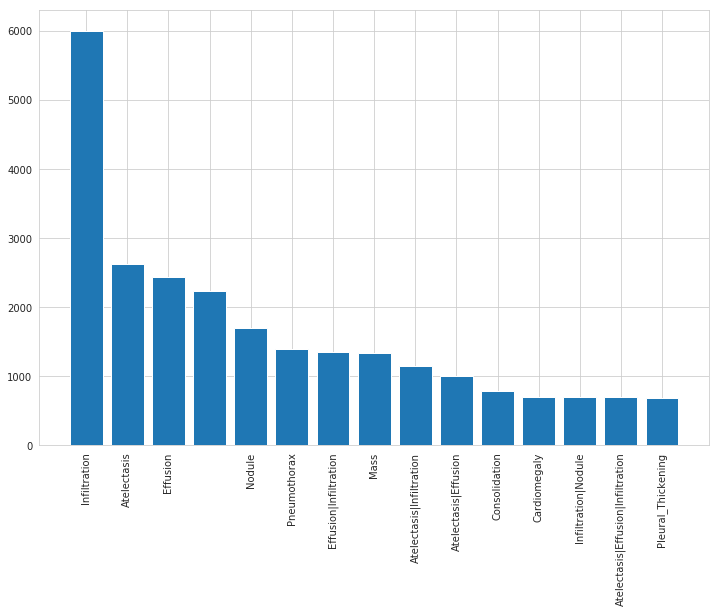

In [5]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.04 + number of findings
sample_weights = data['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
data = data.sample(40000, weights=sample_weights)

label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)


In [6]:
# creating vector of diseases
data['disease_vec'] = data.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])


In [8]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, 
                                   test_size = 0.20, 
                                   random_state = 2018,
                                   stratify = data['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'test', test_df.shape[0])

train 32000 test 8000


In [9]:
train_df, valid_df = train_test_split(train_df, 
                                   test_size = 0.10, 
                                   random_state = 2018,
                                   stratify = train_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'valid', valid_df.shape[0])

train 28800 valid 3200


In [10]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen




In [11]:
from keras.applications.densenet import DenseNet121, preprocess_input

Using TensorFlow backend.


In [12]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
IMG_SIZE = (224, 224) # slightly smaller than vgg16 normally expects
core_idg_dense = ImageDataGenerator()

In [13]:
train_gen = flow_from_dataframe(core_idg_dense, train_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 16)

valid_gen = flow_from_dataframe(core_idg_dense, valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 32) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg_dense, 
                               test_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 8000)) # one big batch
# used a fixed dataset for final evaluation


## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 28800 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3200 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 8000 images


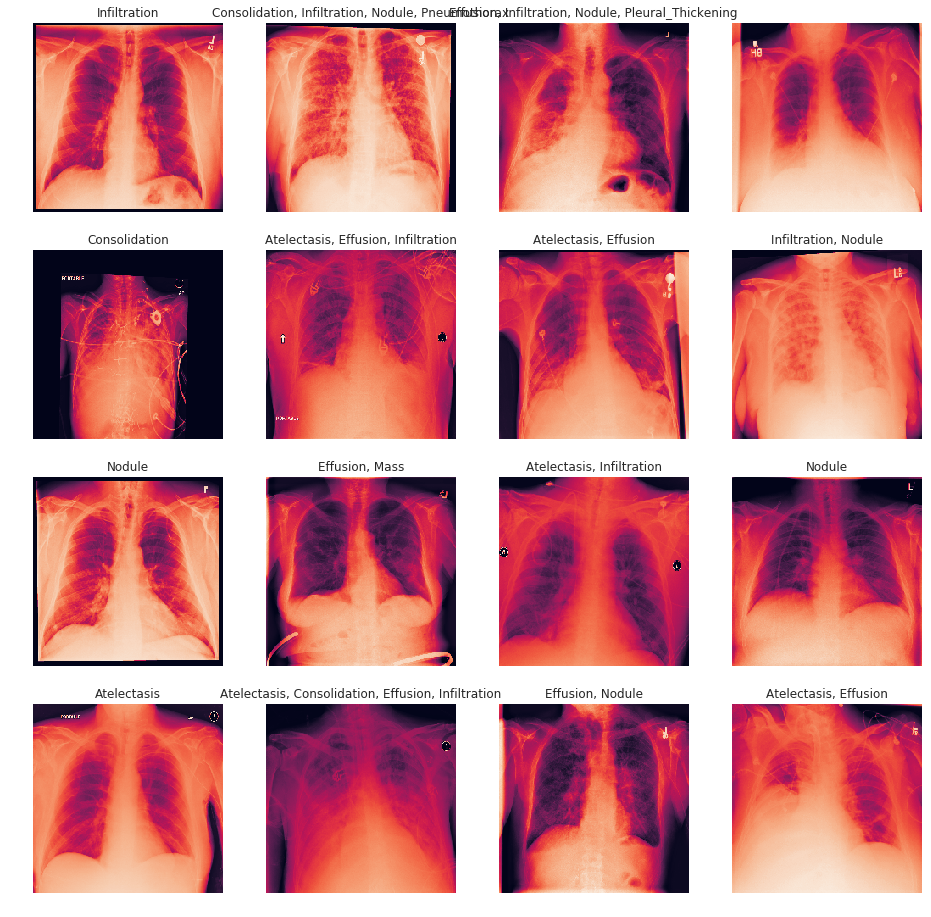

In [14]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0])
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

### DenseNet

In [16]:
# dense net model
img_in = Input(t_x.shape[1:])              #input of model 
model = DenseNet121(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= t_x.shape[1:],
                pooling ='avg') 

x = model.output  
predictions = Dense(len(all_labels), activation="sigmoid", name="predictions")(x)    # fuly connected layer for predict class 
model = Model(inputs=img_in, outputs=predictions)

29089792/29084464 [==============================] - 0s 0us/step


In [17]:
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[keras.metrics.binary_accuracy])

##### training first 20 epochs

In [18]:
history = model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = valid_gen, 
                                  epochs = 20)

Epoch 1/20
100/100 [==============================] - 150s 1s/step - loss: 0.3479 - binary_accuracy: 0.8680 - val_loss: 0.5411 - val_binary_accuracy: 0.8229
Epoch 2/20
100/100 [==============================] - 108s 1s/step - loss: 0.3237 - binary_accuracy: 0.8748 - val_loss: 0.3891 - val_binary_accuracy: 0.8534
Epoch 3/20
100/100 [==============================] - 108s 1s/step - loss: 0.3262 - binary_accuracy: 0.8747 - val_loss: 0.4945 - val_binary_accuracy: 0.8313
Epoch 4/20
100/100 [==============================] - 108s 1s/step - loss: 0.3215 - binary_accuracy: 0.8768 - val_loss: 0.5625 - val_binary_accuracy: 0.7910
Epoch 5/20
100/100 [==============================] - 108s 1s/step - loss: 0.3205 - binary_accuracy: 0.8771 - val_loss: 0.3598 - val_binary_accuracy: 0.8643
Epoch 6/20
100/100 [==============================] - 108s 1s/step - loss: 0.3209 - binary_accuracy: 0.8763 - val_loss: 0.3185 - val_binary_accuracy: 0.8755
Epoch 7/20
100/100 [==============================] - 108s

In [19]:
y_pred = model.predict(test_X)

In [20]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(y_pred,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: actual: 23.11%, predicted: 15.66%
Cardiomegaly: actual: 5.73%, predicted: 4.99%
Consolidation: actual: 9.53%, predicted: 16.48%
Edema: actual: 4.86%, predicted: 5.84%
Effusion: actual: 26.50%, predicted: 35.65%
Emphysema: actual: 4.98%, predicted: 1.62%
Fibrosis: actual: 3.46%, predicted: 2.35%
Infiltration: actual: 38.01%, predicted: 42.80%
Mass: actual: 11.53%, predicted: 16.62%
Nodule: actual: 12.44%, predicted: 14.17%
Pleural_Thickening: actual: 7.27%, predicted: 12.97%
Pneumonia: actual: 2.90%, predicted: 2.82%
Pneumothorax: actual: 10.34%, predicted: 5.61%


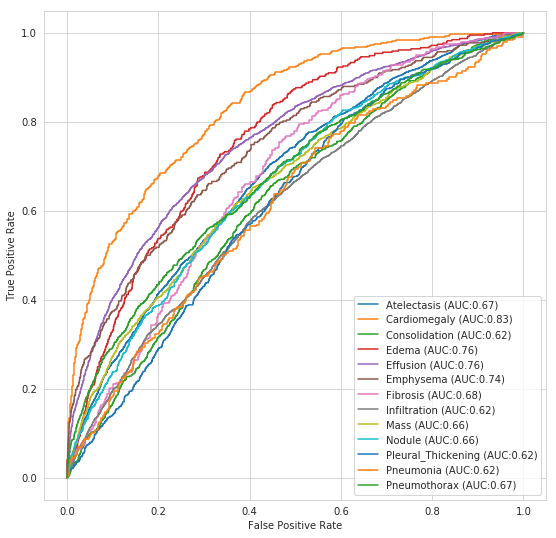

In [21]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')


In [22]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_Y.astype(int), y_pred)

0.6850113880361562

##### training next 20 epochs

In [23]:
history = model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = valid_gen, 
                                  epochs = 20)

Epoch 1/20
100/100 [==============================] - 110s 1s/step - loss: 0.3069 - binary_accuracy: 0.8789 - val_loss: 0.3817 - val_binary_accuracy: 0.8584
Epoch 2/20
100/100 [==============================] - 108s 1s/step - loss: 0.3062 - binary_accuracy: 0.8789 - val_loss: 0.3092 - val_binary_accuracy: 0.8793
Epoch 3/20
100/100 [==============================] - 108s 1s/step - loss: 0.3019 - binary_accuracy: 0.8809 - val_loss: 0.3115 - val_binary_accuracy: 0.8790
Epoch 4/20
100/100 [==============================] - 108s 1s/step - loss: 0.3019 - binary_accuracy: 0.8803 - val_loss: 0.3628 - val_binary_accuracy: 0.8494
Epoch 5/20
100/100 [==============================] - 108s 1s/step - loss: 0.3023 - binary_accuracy: 0.8821 - val_loss: 0.3857 - val_binary_accuracy: 0.8627
Epoch 6/20
100/100 [==============================] - 108s 1s/step - loss: 0.2964 - binary_accuracy: 0.8840 - val_loss: 0.3575 - val_binary_accuracy: 0.8736
Epoch 7/20
100/100 [==============================] - 108s

In [24]:
y_pred = model.predict(test_X)

In [25]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(y_pred,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: actual: 23.11%, predicted: 19.68%
Cardiomegaly: actual: 5.73%, predicted: 9.70%
Consolidation: actual: 9.53%, predicted: 9.81%
Edema: actual: 4.86%, predicted: 3.60%
Effusion: actual: 26.50%, predicted: 32.07%
Emphysema: actual: 4.98%, predicted: 1.92%
Fibrosis: actual: 3.46%, predicted: 2.17%
Infiltration: actual: 38.01%, predicted: 46.69%
Mass: actual: 11.53%, predicted: 8.53%
Nodule: actual: 12.44%, predicted: 10.58%
Pleural_Thickening: actual: 7.27%, predicted: 4.61%
Pneumonia: actual: 2.90%, predicted: 2.77%
Pneumothorax: actual: 10.34%, predicted: 7.22%


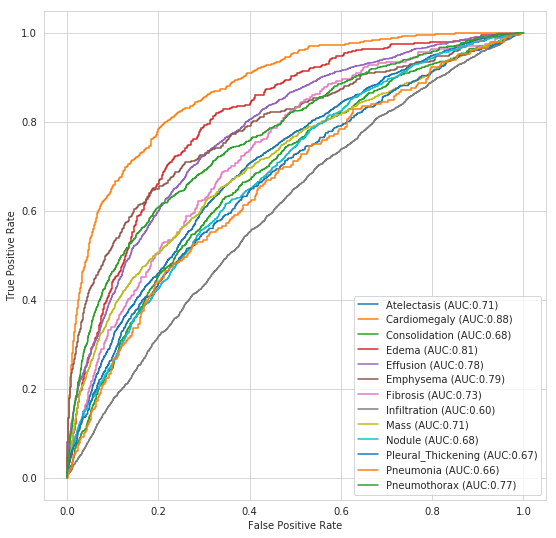

In [26]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')


In [27]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_Y.astype(int), y_pred)

0.7279269166702563

### Observation --
* DenseNet working better than MobileNet 